In [1]:
import os
import random

from einops import rearrange
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from skimage.feature import hog
from tqdm import tqdm

### Presenting data

In [32]:
def read_images(path, size=64):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(size, size),
    )
    
    images, _ = zip(*ds)
    images = np.concatenate(images)
    return images

In [33]:
train_images = read_images('data/train/')
test_images = read_images('data/test/')
labels = sorted(os.listdir('data/train'))

Found 10019 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


In [34]:
print(labels)

['fish', 'five', 'four', 'mega', 'mirror', 'pyra', 'square', 'squeb', 'three', 'two']


In [35]:
def show_random_images(images, cmap=None):
    choosen = random.choices(images, k=25)
    choosen = rearrange(choosen, '(nh nw) h w c -> (nh h) (nw w) c', nw=5).astype(int)
    plt.imshow(choosen, cmap)

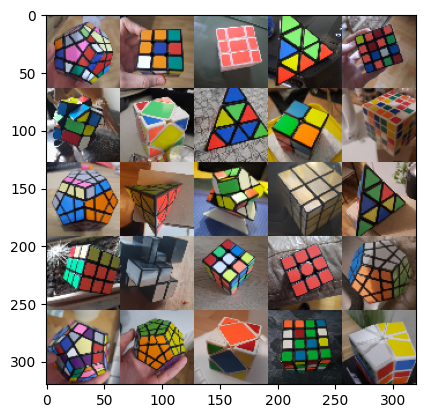

In [36]:
show_random_images(train_images)

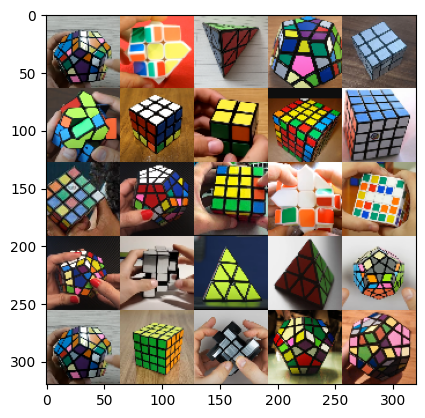

In [37]:
show_random_images(test_images)

# HOG

In [19]:
def apply_hog(rgb_image):
    gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY) / 256
    result = hog(gray_image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=None, feature_vector=False)
    return np.squeeze(result)

In [20]:
def read_hog_images(path, size):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(size, size),
        batch_size=1
    )
    
    X = []
    y = []
    
    for rgb_image, label in tqdm(ds, total=len(ds)):
        hog_image = apply_hog(rgb_image[0].numpy())
        X.append(hog_image)
        y.append(label[0].numpy())
        
    X = np.array(X)
    y = np.array(y)
    return X, y

In [21]:
train_X, train_y = read_hog_images('data/train/', size=512)
test_X, test_y = read_hog_images('data/test/', size=512)

Found 10019 files belonging to 10 classes.


100%|██████████| 10019/10019 [07:36<00:00, 21.94it/s]


Found 500 files belonging to 10 classes.


100%|██████████| 500/500 [00:21<00:00, 23.35it/s]


### Creating CNN

In [24]:
model = Sequential([
    layers.Input(shape=(32, 32, 9)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        2624      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 6, 6, 128)       

In [25]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [26]:
callbacks   = [
      EarlyStopping(monitor='val_categorical_accuracy', patience=10, mode='max', restore_best_weights=True),
      ModelCheckpoint('data/model.tf', monitor='val_categorical_accuracy', save_best_only=True, mode='max'),
]

history = model.fit(
    train_X,
    train_y,
    validation_data=(test_X, test_y),
    epochs=500,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/500
157/157 [==============================] - ETA: 0s - loss: 2.1305 - categorical_accuracy: 0.1757

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 4s 19ms/step - loss: 2.1305 - categorical_accuracy: 0.1757 - val_loss: 1.7076 - val_categorical_accuracy: 0.3380
Epoch 2/500
157/157 [==============================] - ETA: 0s - loss: 1.4299 - categorical_accuracy: 0.4292

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 2s 14ms/step - loss: 1.4299 - categorical_accuracy: 0.4292 - val_loss: 1.6832 - val_categorical_accuracy: 0.4100
Epoch 3/500
155/157 [============================>.] - ETA: 0s - loss: 0.8074 - categorical_accuracy: 0.7001

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 2s 14ms/step - loss: 0.8053 - categorical_accuracy: 0.7009 - val_loss: 1.6653 - val_categorical_accuracy: 0.5020
Epoch 4/500
154/157 [============================>.] - ETA: 0s - loss: 0.5213 - categorical_accuracy: 0.8089

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 2s 14ms/step - loss: 0.5190 - categorical_accuracy: 0.8098 - val_loss: 1.2990 - val_categorical_accuracy: 0.6040
Epoch 5/500
152/157 [============================>.] - ETA: 0s - loss: 0.3695 - categorical_accuracy: 0.8703

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 2s 15ms/step - loss: 0.3672 - categorical_accuracy: 0.8708 - val_loss: 1.6772 - val_categorical_accuracy: 0.6080
Epoch 6/500
157/157 [==============================] - 1s 9ms/step - loss: 0.2604 - categorical_accuracy: 0.9123 - val_loss: 2.1093 - val_categorical_accuracy: 0.5820
Epoch 7/500
156/157 [============================>.] - ETA: 0s - loss: 0.2075 - categorical_accuracy: 0.9315

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 2s 14ms/step - loss: 0.2073 - categorical_accuracy: 0.9315 - val_loss: 1.6314 - val_categorical_accuracy: 0.6860
Epoch 8/500
157/157 [==============================] - 1s 9ms/step - loss: 0.1448 - categorical_accuracy: 0.9550 - val_loss: 1.8528 - val_categorical_accuracy: 0.6460
Epoch 9/500
157/157 [==============================] - 1s 9ms/step - loss: 0.1044 - categorical_accuracy: 0.9687 - val_loss: 2.0657 - val_categorical_accuracy: 0.6560
Epoch 10/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0884 - categorical_accuracy: 0.9734 - val_loss: 2.3731 - val_categorical_accuracy: 0.6440
Epoch 11/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0703 - categorical_accuracy: 0.9771 - val_loss: 2.3833 - val_categorical_accuracy: 0.6780
Epoch 12/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0453 - categorical_accuracy: 0.9867 - val_loss: 2.5229 - val_categorical_accuracy: 0.6540
Epoch 

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 2s 14ms/step - loss: 0.0853 - categorical_accuracy: 0.9765 - val_loss: 2.0973 - val_categorical_accuracy: 0.6980
Epoch 16/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0335 - categorical_accuracy: 0.9898 - val_loss: 3.1388 - val_categorical_accuracy: 0.6560
Epoch 17/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0459 - categorical_accuracy: 0.9869 - val_loss: 3.5502 - val_categorical_accuracy: 0.5980
Epoch 18/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0239 - categorical_accuracy: 0.9935 - val_loss: 2.3492 - val_categorical_accuracy: 0.6940
Epoch 19/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0435 - categorical_accuracy: 0.9872 - val_loss: 2.9341 - val_categorical_accuracy: 0.6380
Epoch 20/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0440 - categorical_accuracy: 0.9888 - val_loss: 4.0031 - val_categorical_accuracy: 0.5760
Epoc

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 2s 14ms/step - loss: 0.0154 - categorical_accuracy: 0.9949 - val_loss: 2.3767 - val_categorical_accuracy: 0.7160
Epoch 24/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0335 - categorical_accuracy: 0.9909 - val_loss: 2.2368 - val_categorical_accuracy: 0.6960
Epoch 25/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0266 - categorical_accuracy: 0.9921 - val_loss: 2.6505 - val_categorical_accuracy: 0.6900
Epoch 26/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0266 - categorical_accuracy: 0.9915 - val_loss: 2.7506 - val_categorical_accuracy: 0.6680
Epoch 27/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0272 - categorical_accuracy: 0.9924 - val_loss: 2.1446 - val_categorical_accuracy: 0.6980
Epoch 28/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0159 - categorical_accuracy: 0.9958 - val_loss: 2.8199 - val_categorical_accuracy: 0.6900
Epoc

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 2s 15ms/step - loss: 0.0483 - categorical_accuracy: 0.9870 - val_loss: 1.8309 - val_categorical_accuracy: 0.7400
Epoch 31/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0302 - categorical_accuracy: 0.9917 - val_loss: 2.2206 - val_categorical_accuracy: 0.6780
Epoch 32/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0166 - categorical_accuracy: 0.9955 - val_loss: 2.7114 - val_categorical_accuracy: 0.6880
Epoch 33/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0077 - categorical_accuracy: 0.9986 - val_loss: 3.0732 - val_categorical_accuracy: 0.6860
Epoch 34/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0331 - categorical_accuracy: 0.9919 - val_loss: 3.1250 - val_categorical_accuracy: 0.6240
Epoch 35/500
157/157 [==============================] - 1s 9ms/step - loss: 0.0290 - categorical_accuracy: 0.9918 - val_loss: 2.4856 - val_categorical_accuracy: 0.6660
Epoc

### Results

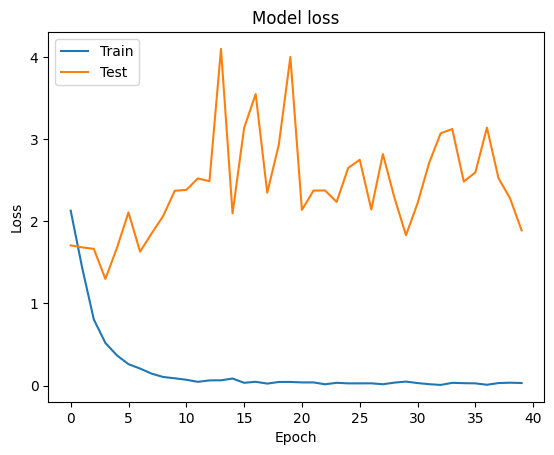

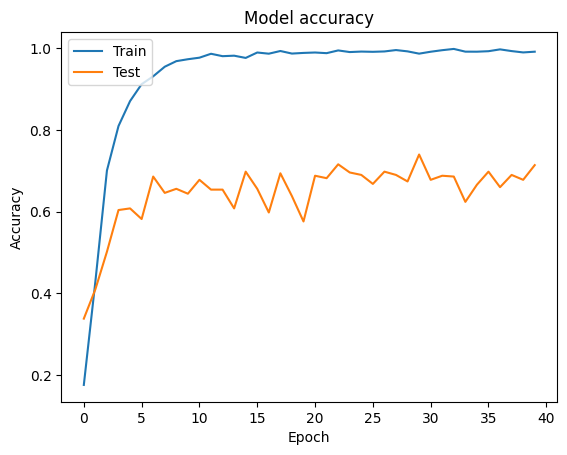

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

16/16 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.59      0.80      0.68        50
           1       0.74      0.86      0.80        50
           2       0.74      0.58      0.65        50
           3       0.80      0.94      0.86        50
           4       0.39      0.48      0.43        50
           5       0.84      0.98      0.91        50
           6       0.98      0.88      0.93        50
           7       0.98      0.88      0.93        50
           8       0.67      0.66      0.67        50
           9       1.00      0.34      0.51        50

    accuracy                           0.74       500
   macro avg       0.77      0.74      0.74       500
weighted avg       0.77      0.74      0.74       500



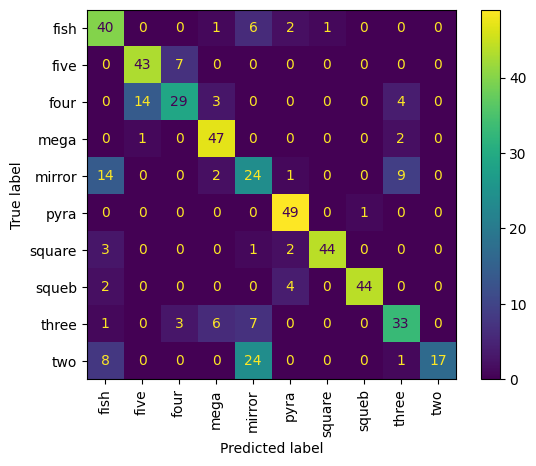

In [39]:
predictions = model.predict(test_X)
true_classes = np.argmax(test_y, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    display_labels=labels, 
    xticks_rotation='vertical',
);